# Gao et al., 2018 - A DataJoint example

This notebook replicates selected figures from Gao et al., 2018. **A cortico-cerebellar loop for motor planning**  

Link to the publication:  https://www.nature.com/articles/s41586-018-0633-x  
Link to the original data: http://crcns.org/data-sets/motor-cortex/alm-4/  
Link to the exported NWB files: https://drive.google.com/drive/u/1/folders/1I9Sur9TRzts_u35OP_XEFlMYnKBJfCPS  

This study revealed a cortical-cerebellar loop for motor planning with electrophysiological recording and optogenetics perturbations, within a behavioral paradigm of delayed somatosensory discrimination task. The two brain areas studied were anterior lateral motor cortex (ALM), and cerebellar nuclei (CN). The study first shows that both ALM and CN are responsive during the delay period (Fig 2), and are selective to trials in one location, suggesting their roles in motor planning. Inibibition of either ALM or CN disrupted the selectivity of the other area (Fig 3). Finally, the study compared the effect of activating Dentate and Fastigial cerebellar nuclei on the discriminability of the ALM neurons (Fig 4), and found that Fastigial nucleus is more important for ALM discriminability during the delay period.

A ***DataJoint*** data pipeline has been constructed for this study, with the presented data ingested into this pipeline. This notebook demonstrates the queries, processing, and reproduction of several figures from the paper. From the pipeline, export capability to ***NWB 2.0*** format is also available.

In this notebook, we replicated the a subset of the major results, from the data recorded in ALM.

In [1]:
%matplotlib notebook

In [2]:
import datajoint as dj
from pipeline import ephys, behavior, subject, acquisition
import numpy as np
import matplotlib.pyplot as plt
from pipeline import get_spk_counts, get_trials, get_spk_times, get_psth
import scipy.signal as signal
import scipy.stats as ss
import datetime
import numpy.random as random

Connecting shan@host.docker.internal:3306


## Figure 2c

In [3]:
# helper function
def compute_mean_and_sem(fr):
    mean_fr = np.average(fr, axis=0)
    sem_fr = np.divide(np.std(fr, axis=0), np.sqrt(np.shape(fr)[0]))
    return mean_fr, sem_fr

In [4]:
# restrict to photo activation sessions
sessions = acquisition.Session & (behavior.TrialSetType & 'trial_set_type = "photo activation"')

# restrict to pyramidal cells, no light trials, only hit trials, trial number > 15
valid_cells = (ephys.UnitSelectivity & sessions & 
           (ephys.UnitSpikeTimes & 'unit_cell_type = "pyramidal"') & 
           'trial_condition = "Hit"' &
           'l_trial_number > 15' &
           'r_trial_number > 15' & 'selectivity=1')

# restrict to selective units
fr_diff, bins = valid_cells.fetch('psth_diff_test', 'bins')
fr_diff = np.array(fr_diff.tolist())

In [5]:
mean_fr, sem_fr = compute_mean_and_sem(fr_diff)

In [6]:
xlim = [-3, 2]
ylim = [-1, 4]
time_points = [-2.6, -1.3, 0]

<IPython.core.display.Javascript object>


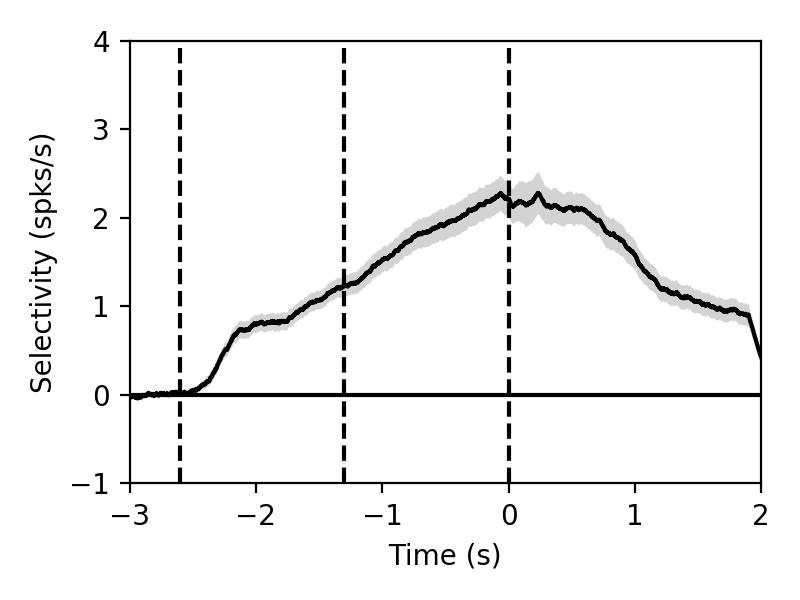

In [7]:
fig, ax = plt.subplots(1, 1, figsize=[4,3])
for time_point in time_points:
    ax.axvline(x=time_point, color='black', linestyle='dashed')
ax.axhline(y=0, color='black')
ax.fill_between(bins[0], mean_fr+sem_fr, mean_fr-sem_fr, facecolor="lightgray")
ax.plot(bins[0], mean_fr, color="black")
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Selectivity (spks/s)')
fig.tight_layout()

Three dashed vertical lines marked the onset of sample period, delay period, and the response period, individually. The plot shows that ALM neurons are selective from the sampling period to the delay period, suggesting its role in motor planning.

## Figure 3 e, f

In [8]:
# restrict to photo inhibition sessions
sessions = acquisition.Session & (behavior.TrialSetType & 'trial_set_type = "photo inhibition"')

# light off condition
light_off = ephys.UnitSelectivity & sessions & \
              (ephys.UnitSpikeTimes & 'unit_cell_type = "pyramidal"') &\
              'selectivity > 0' & 'trial_condition = "All"'
light_on = ephys.AlignedPsthStimOn & sessions & light_off &  'photo_stim_id="6"'& \
              (ephys.UnitSpikeTimes & 'unit_cell_type = "pyramidal"') & 'trial_condition = "All"'

fr_diff_off, bins = light_off.fetch('psth_diff_test', 'bins')
fr_diff_on = light_on.fetch('psth_diff_on')

fr_diff_off = np.array(fr_diff_off.tolist())
fr_diff_on = np.array(fr_diff_on.tolist())

In [9]:
mean_fr_off, sem_fr_off = compute_mean_and_sem(fr_diff_off)
mean_fr_on, sem_fr_on = compute_mean_and_sem(fr_diff_on)

In [10]:
mean_fr = [mean_fr_off, mean_fr_on]
sem_fr = [sem_fr_off, sem_fr_on]

<IPython.core.display.Javascript object>


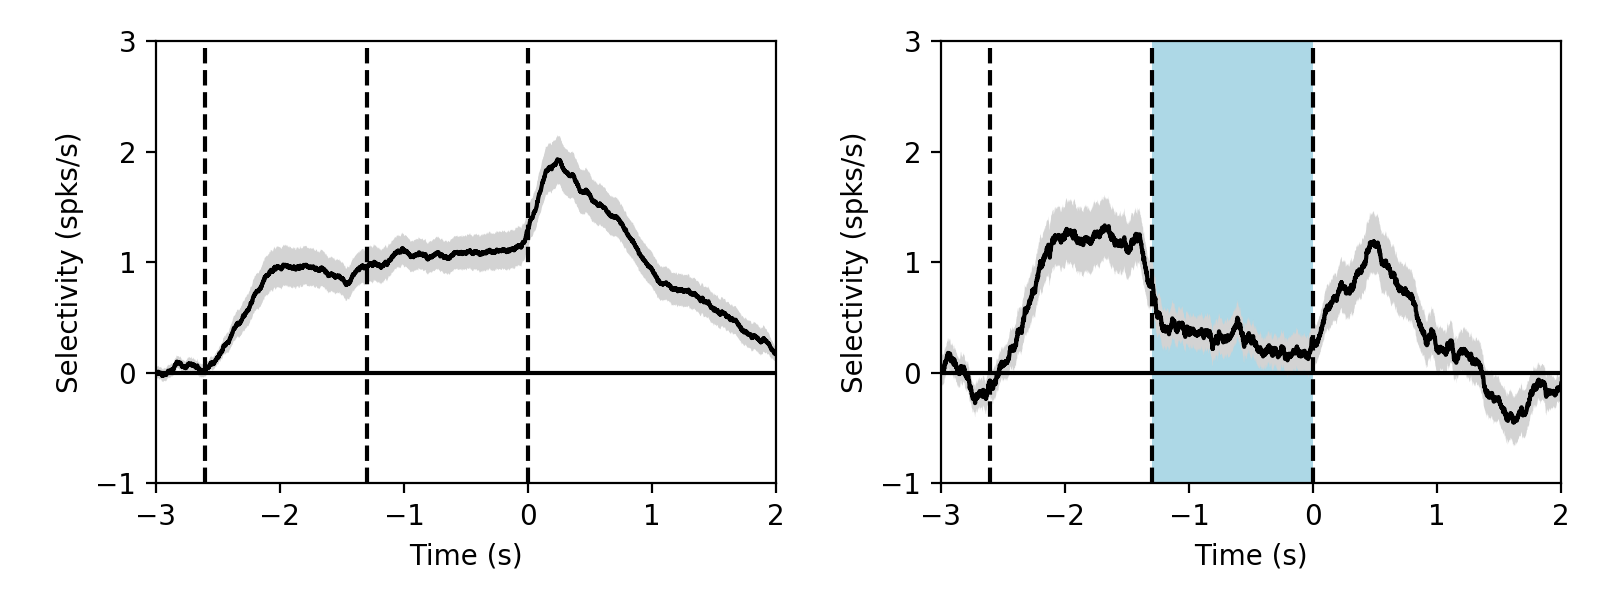

In [11]:
ylim = [-1, 3]
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(8,3))
for ix, ax in enumerate(axs):
    for time_point in time_points:
        ax.axvline(x=time_point, color='black', linestyle='dashed')
    if ix == 1:
        ax.fill_between(time_points[1:], [ylim[0], ylim[0]], [ylim[1], ylim[1]], facecolor="lightblue")
    ax.axhline(y=0, color='black')
    ax.fill_between(bins[0], mean_fr[ix]+sem_fr[ix], mean_fr[ix]-sem_fr[ix], facecolor="lightgray")
    ax.plot(bins[0], mean_fr[ix], color="black")
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Selectivity (spks/s)')

fig.tight_layout()
fig.savefig('/images/photo_inhibition.png', dpi=300)

The left panel is the ALM selectivity without light perturbation, while the right panel is with photoinihibition in the cerebellar neuclei. The ALM selectivity is disrupted with CN inhibition.

In [13]:
selectivity, fr_light_off, fr_light_on = (ephys.UnitSelectivity() * ephys.AlignedPsthStimOn & 
                                          'photo_stim_id="6"' & sessions & \
                                          (ephys.UnitSpikeTimes & 'unit_cell_type = "pyramidal"') &\
                                          'trial_condition = "All"').fetch(
                                                'mean_fr_diff_rl_all', 'mean_fr_all', 'mean_fr_all_on')

In [14]:
selectivity = [fr[1] for fr in selectivity]
fr_diff_photo = [fr_on[1] - fr_off[1] for fr_off, fr_on in zip(fr_light_off, fr_light_on)]

<IPython.core.display.Javascript object>


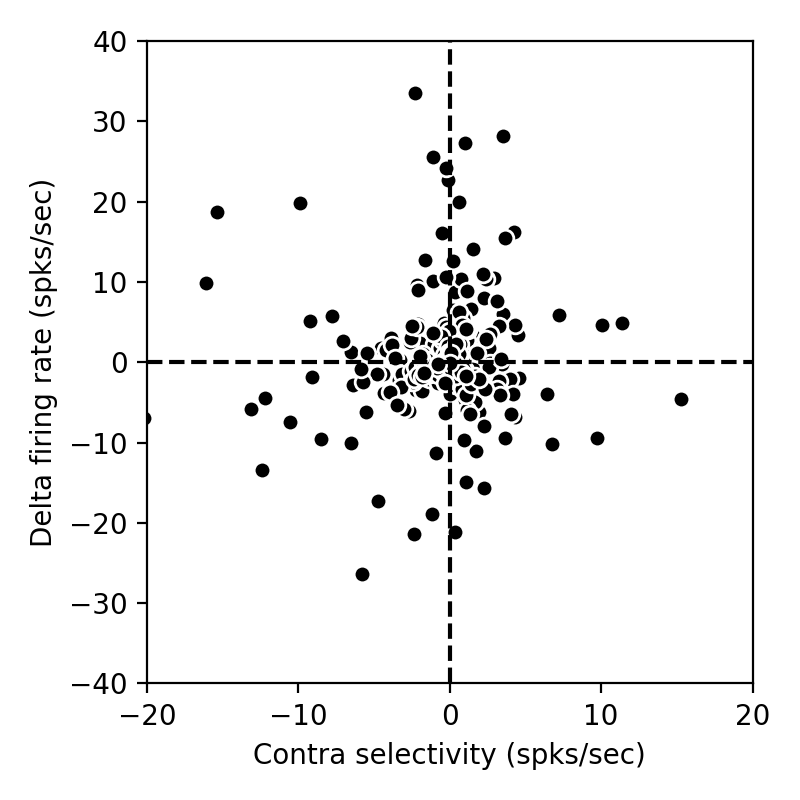

In [17]:
fig2, ax = plt.subplots(1, 1, figsize=[4,4])
ax.scatter(selectivity, fr_diff_photo, color='k', edgecolors='w')
ax.set_xlim([-20, 20])
ax.set_ylim([-40, 40])
ax.axvline(x=0, color='black', linestyle='dashed')
ax.axhline(y=0, color='black', linestyle='dashed')
ax.set_xlabel('Contra selectivity (spks/sec)')
ax.set_ylabel('Delta firing rate (spks/sec)')
fig2.tight_layout()
fig2.savefig('/images/photo_inhibition_summary.png', dpi=300)

## Figure 4i

In [13]:
# light off condition
light_off = ephys.ProjectedPsth & 'photo_stim_id = "0"'
# FS on condition
fst_act = ephys.ProjectedPsth & 'photo_stim_id="2"'
# DN on condition
dn_act = ephys.ProjectedPsth & 'photo_stim_id="4"'

<IPython.core.display.Javascript object>


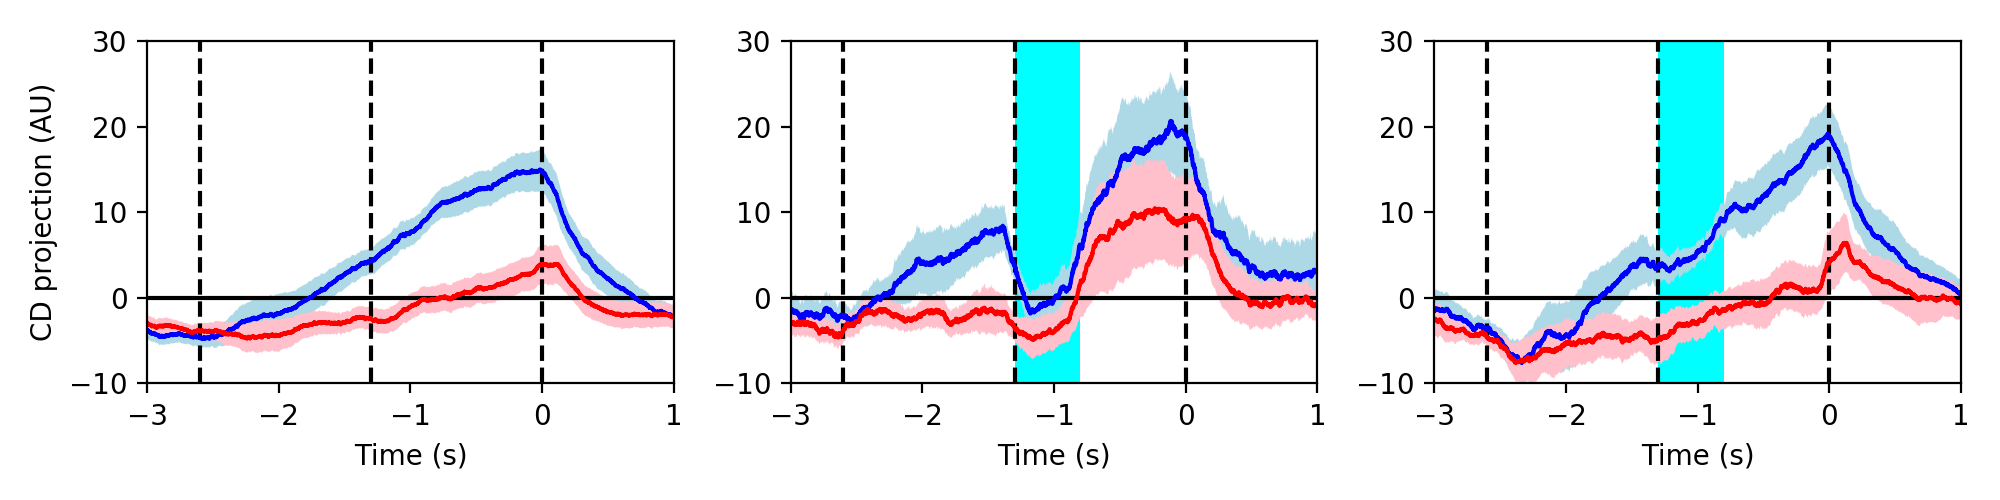

In [14]:
ylim = [-10, 30]
xlim = [-3, 1]

time_window = [-3.5, 2]
bins = np.arange(time_window[0], time_window[1]+0.001, 0.001)
fig3, axs = plt.subplots(1, 3, figsize=(10, 2.5))

for iax, ax in enumerate(axs):
    if iax == 0:
        projected_left, projected_right = light_off.fetch(
            'proj_psth_l', 'proj_psth_r')
    elif iax == 1:
        projected_left, projected_right = fst_act.fetch(
            'proj_psth_l', 'proj_psth_r')
    elif iax == 2:
        projected_left, projected_right = dn_act.fetch(
            'proj_psth_l', 'proj_psth_r')
    mean_psth_l, sem_psth_l = compute_mean_and_sem(projected_left)
    mean_psth_r, sem_psth_r = compute_mean_and_sem(projected_right)
    if iax in [1, 2]:
        ax.fill_between([-1.3, -0.8], [ylim[0], ylim[0]], [ylim[1], ylim[1]], facecolor="cyan")
    for time_point in time_points:
        ax.axvline(x=time_point, color='black', linestyle='dashed')
    ax.axhline(y=0, color='black')
    ax.fill_between(bins, mean_psth_r+sem_psth_r, mean_psth_r-sem_psth_r, facecolor="lightblue")
    ax.plot(bins, mean_psth_r, color="blue")
    ax.fill_between(bins, mean_psth_l+sem_psth_l, mean_psth_l-sem_psth_l, facecolor="pink")
    ax.plot(bins, mean_psth_l, color="red")
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    
    ax.set_xlabel('Time (s)')
    if iax == 0:
        ax.set_ylabel('CD projection (AU)')

fig3.tight_layout()
fig3.savefig('/images/photo_activation.png', dpi=300)

The three panels are the ALM activity projecting on its coding direction, with no photoactivation (left), activation on the fastigial nucleus (middle), and dentate nucleus (right). Consistent with the published results, the effect of fastgial nucleus is big while the effect of dentate nucleus is minimal.